# Matrix Factorisation - Implicit

Implicit Matrix Factorization 

- Where ratings of less than threshold are implied as preferences
- Also uses negative sampling to improve performance

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split, neg_feedback_samples, remove_year
from reco.evaluate import user_item_crossjoin, filter_by

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
df_implicit = neg_feedback_samples(df_ratings, rating_threshold=3, ratio_neg_per_user=1)
df_implicit["unix_timestamp"] = 1

In [6]:
df_implicit.head()

,user_id,movie_id,rating,unix_timestamp
0,1,61,1,1
298,1,885,0,1
297,1,1096,0,1
296,1,1458,0,1
295,1,1099,0,1


In [7]:
df_ratings.shape, df_implicit.shape

((99815, 4), (164798, 4))

In [8]:
df_items['cleaned_title'] = df_items['title'].apply(remove_year)
df_items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count,cleaned_title
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,1995.0,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0,Toy Story
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,1,0,0,1995.0,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0,GoldenEye
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,1,0,0,1995.0,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0,Four Rooms
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,1995.0,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0,Get Shorty
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,1,0,0,1995.0,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0,Copycat


In [9]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_implicit, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1663


In [10]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1663)

In [11]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(0, 1)

In [12]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = random_split(DATA, [0.8, 0.2])

In [13]:
train.shape, test.shape

((131838, 5), (32960, 5))

## Implicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [15]:
def ImplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [16]:
n_factors = 40
model = ImplicitMF(n_users, n_items, n_factors)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbedding (Embedding)     │ (None, 1, 40)             │          66,520 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbedding (Embedding)     │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemsE (Flatten)       │ (None, 40)                │               0 │ ItemEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsersE (Flatten)       │ (None, 40)                │               0 │ UserEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenItemsE[0][0],       │
│                               │                           │                 │ FlattenUsersE[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 104,240 (407.19 KB)

 Trainable params: 104,240 (407.19 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


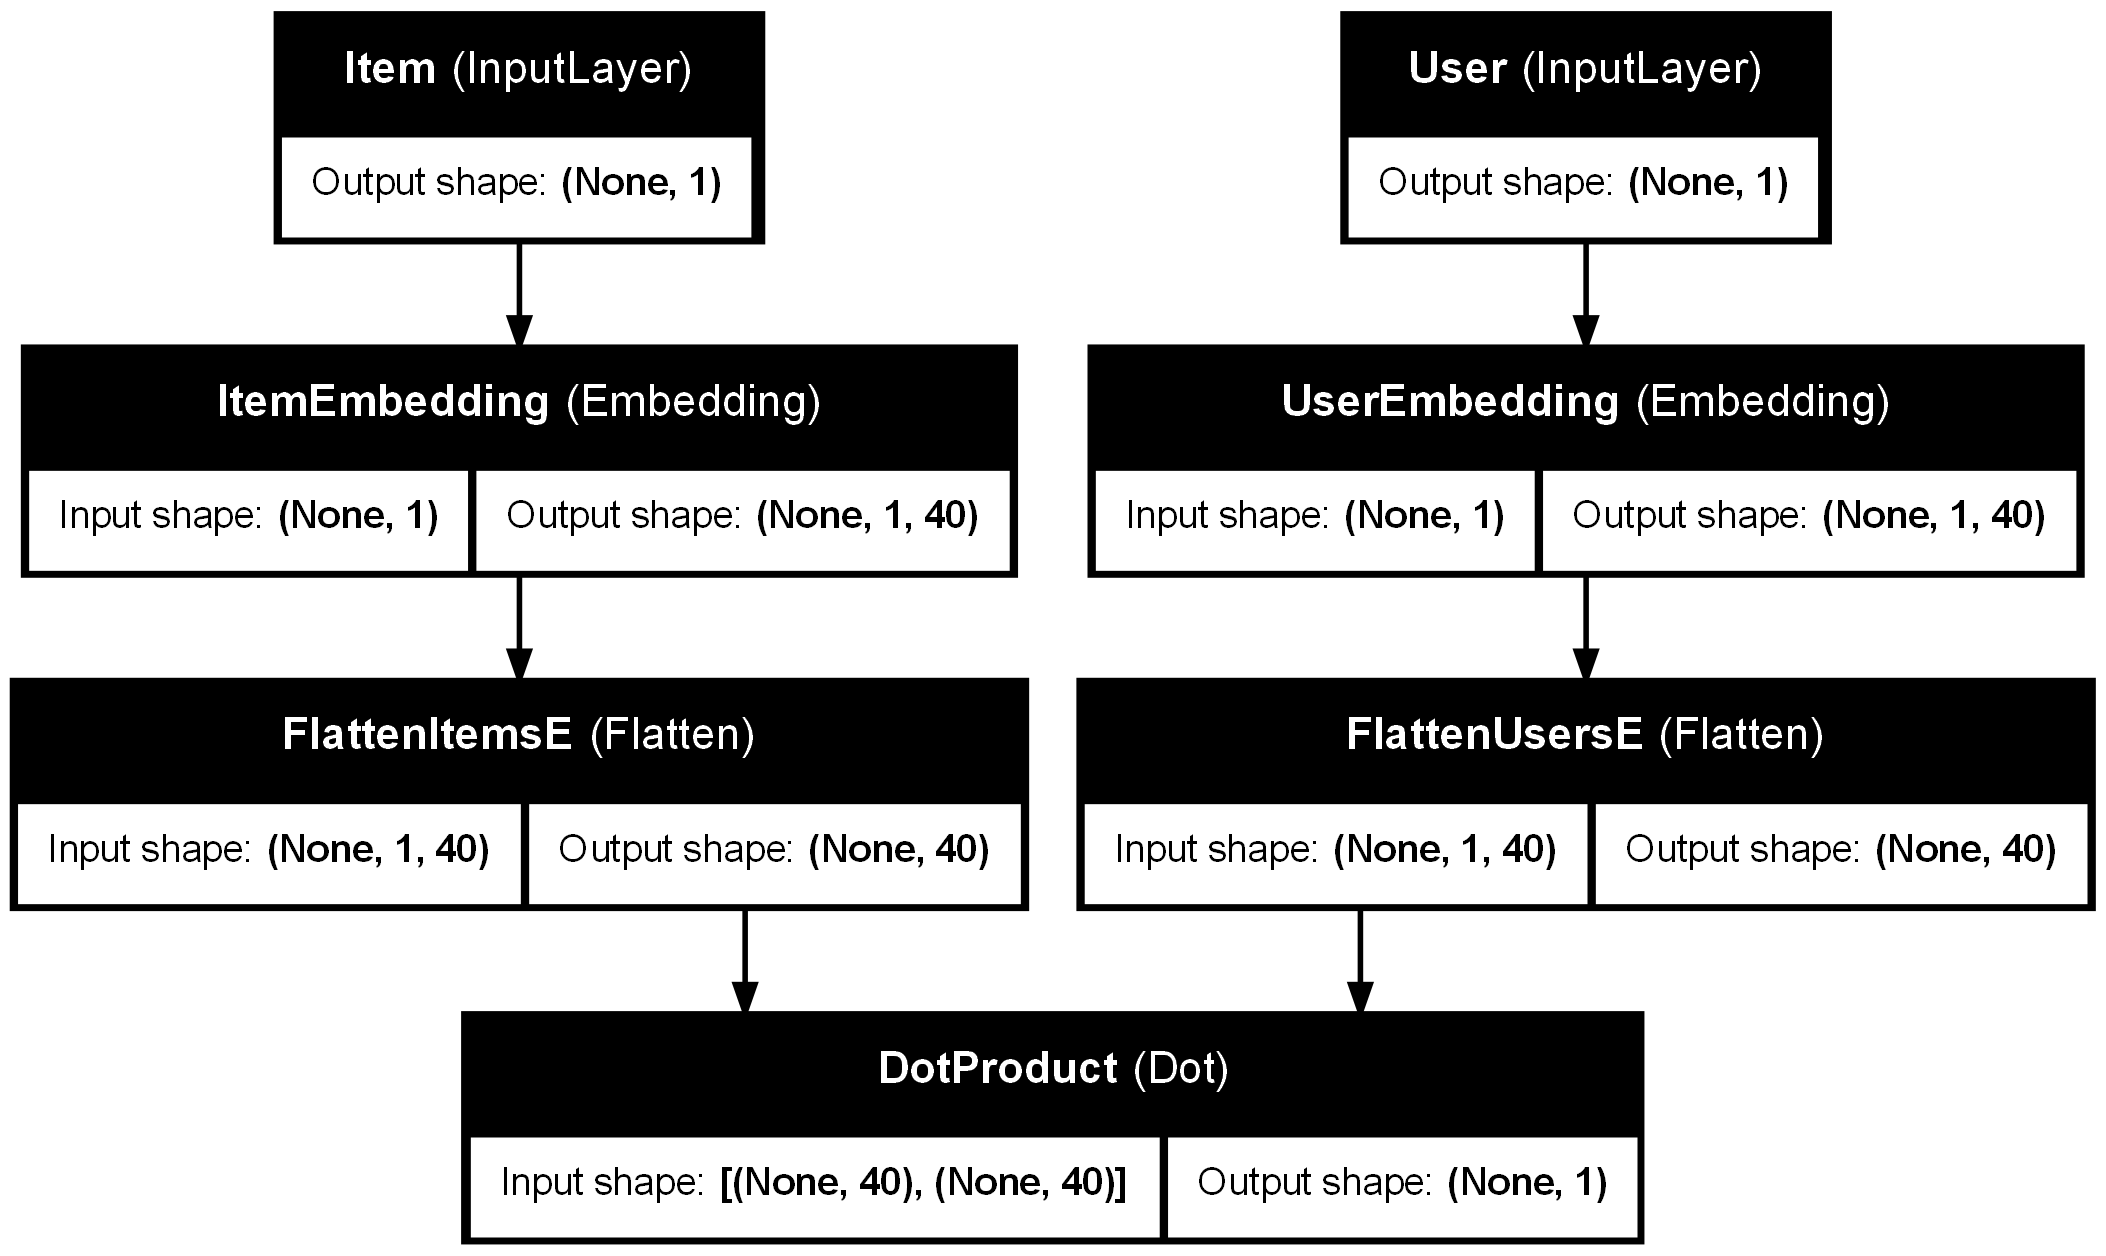

In [19]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/implicit-mf.png" )

### Train the Model

In [20]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.3743 - val_loss: 5.4219
Epoch 2/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.4633 - val_loss: 5.3324
Epoch 3/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.4249 - val_loss: 5.2923
Epoch 4/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 2.6718 - val_loss: 5.2942
Epoch 5/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 2.2771 - val_loss: 5.2700
Wall time: 1min 1s


In [21]:
#vis.metrics(output.history)

### Score the Model

In [22]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 5.0532


5.20182466506958

### Evaluate the Model

In [23]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [24]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [25]:
%%time
predictions = get_predictions(model, DATA)

49007/49007 ━━━━━━━━━━━━━━━━━━━━ 387s 8ms/step
Wall time: 12min 20s


In [26]:
predictions.head()

,USER,ITEM,RATING_PRED
0,0,60,-0.019965
1,0,879,0.049989
2,0,1088,0.259003
3,0,1444,-0.193970
4,0,1091,0.169781


In [27]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49007/49007 ━━━━━━━━━━━━━━━━━━━━ 334s 7ms/step
Wall time: 9min 20s


In [28]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.118005
Precision@K:	0.081726
Recall@K:	0.004983


### Get Similar Items

In [29]:
from reco.recommend import get_similar, show_similar

In [30]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 201 ms


In [31]:
item_similar_indices

array([[   0,  992,  133, 1055,  827],
       [   1,  661,   20,  466, 1128],
       [   2,  547,  217,  232,  138],
       ...,
       [1660, 1429, 1341, 1252, 1359],
       [1661, 1463,  895, 1549, 1591],
       [1662,  847,  246, 1568, 1604]], dtype=int64)

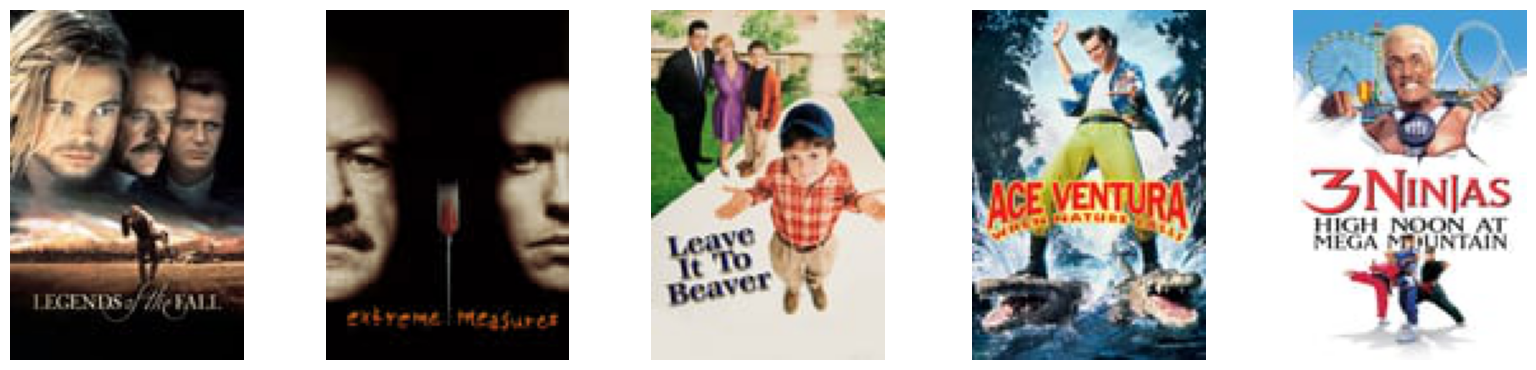

In [35]:
show_similar("star wars", item_similar_indices, item_encoder, df_items)